In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels as ols

import warnings
warnings.filterwarnings('ignore')

import time

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from statsmodels.formula.api import logit

In [2]:
# READ IN DATA
killsData = pd.read_csv('kills.csv')
roundViewData = pd.read_csv('round_view.csv')

In [3]:
%%time
matchNames = (roundViewData['file']).unique()
updatedKillsData = pd.DataFrame()

for i in range( 40 ):
    numberOfRounds = roundViewData[roundViewData['file'] == matchNames[i]].shape[0]
    roundSplit = killsData[killsData['file'] == matchNames[i]].get('seconds').diff()
    roundSplitArr = roundSplit[roundSplit <= 0].index
    startOfDifGame = killsData[killsData['file'] == matchNames[i+1]].get('seconds').diff().index[0]
    
#     print(startOfDifGame)
    
    #Iterate through round ranges(for killsData) to apply new columns     
    for j in range(len(roundSplitArr)):
        currentRoundInfo = roundViewData.iloc[j]
        
#         print(roundSplitArr[j])
#         print("VALUE OF J:", j)

        #First and Second Round Condition     
        if j == 0 and roundSplitArr[j] != 0:
            #For the first round        
            updatedKillsData = updatedKillsData.append(killsData.iloc[0:roundSplitArr[j]].assign(**{
                'Round_Type': currentRoundInfo['round_type'],
                'Winner_Side' : currentRoundInfo['winner_side'],
                'Ct_Eq_Val': currentRoundInfo['ct_eq_val'],
                'T_Eq_Val': currentRoundInfo['t_eq_val'],
                'map': currentRoundInfo['map']
            }))
            
            #Update for next Round           
            currentRoundInfo = roundViewData.iloc[j+1]
            updatedKillsData = updatedKillsData.append(killsData.iloc[roundSplitArr[j]:roundSplitArr[j+1]].assign(**{
                'Round_Type': currentRoundInfo['round_type'],
                'Winner_Side' : currentRoundInfo['winner_side'],
                'Ct_Eq_Val': currentRoundInfo['ct_eq_val'],
                'T_Eq_Val': currentRoundInfo['t_eq_val'],
                'map': currentRoundInfo['map']
            }))
      
#             print(updatedKillsData)
        
        #Last Round Condition
        elif j == (len(roundSplitArr) - 1):
            updatedKillsData = updatedKillsData.append(killsData.iloc[roundSplitArr[j]:startOfDifGame].assign(**{
                'Round_Type': currentRoundInfo['round_type'],
                'Winner_Side' : currentRoundInfo['winner_side'],
                'Ct_Eq_Val': currentRoundInfo['ct_eq_val'],
                'T_Eq_Val': currentRoundInfo['t_eq_val'],
                'map': currentRoundInfo['map']
            }))
#             print(updatedKillsData)

        #All Other Rounds      
        else:
            updatedKillsData = updatedKillsData.append(killsData.iloc[roundSplitArr[j]:roundSplitArr[j+1]].assign(**{
                'Round_Type': currentRoundInfo['round_type'],
                'Winner_Side' : currentRoundInfo['winner_side'],
                'Ct_Eq_Val': currentRoundInfo['ct_eq_val'],
                'T_Eq_Val': currentRoundInfo['t_eq_val'],
                'map': currentRoundInfo['map']
            }))
#             print(updatedKillsData)
        
#         print('=======================')


Wall time: 32.8 s


# DATA CLEANING

In [4]:
#updatedKillsData['Winner_Side'].value_counts()
updatedKillsData.head()

,Unnamed: 0,file,seconds,ct_alive,t_alive,is_bomb_planted,wp_type,is_ct,Round_Type,Winner_Side,Ct_Eq_Val,T_Eq_Val,map
0,0,esea_match_13770997.dem,30.74165,5,4,0,Pistol,1,PISTOL_ROUND,Terrorist,4300,4250,de_overpass
1,1,esea_match_13770997.dem,31.93185,4,4,0,Pistol,0,PISTOL_ROUND,Terrorist,4300,4250,de_overpass
2,2,esea_match_13770997.dem,34.28094,3,4,0,Pistol,0,PISTOL_ROUND,Terrorist,4300,4250,de_overpass
3,3,esea_match_13770997.dem,38.93212,3,3,0,Pistol,1,PISTOL_ROUND,Terrorist,4300,4250,de_overpass
4,4,esea_match_13770997.dem,40.76441,2,3,0,Pistol,0,PISTOL_ROUND,Terrorist,4300,4250,de_overpass


In [5]:
ct_win = updatedKillsData.loc[updatedKillsData['Winner_Side'] == 'CounterTerrorist']

tr_win = updatedKillsData.loc[updatedKillsData['Winner_Side'] == 'Terrorist']
random_tr_sample = tr_win.sample(ct_win.shape[0])

In [6]:
equal_dataset = pd.concat([ct_win, random_tr_sample], axis = 0)

In [7]:
equal_dataset

,Unnamed: 0,file,seconds,ct_alive,t_alive,is_bomb_planted,wp_type,is_ct,Round_Type,Winner_Side,Ct_Eq_Val,T_Eq_Val,map
38,38,esea_match_13770997.dem,40.38855,4,5,0,Rifle,0,ECO,CounterTerrorist,5400,20550,de_overpass
39,39,esea_match_13770997.dem,43.39539,3,5,0,Rifle,0,ECO,CounterTerrorist,5400,20550,de_overpass
40,40,esea_match_13770997.dem,48.93921,3,4,0,Rifle,1,ECO,CounterTerrorist,5400,20550,de_overpass
41,41,esea_match_13770997.dem,61.76520,3,3,0,Rifle,1,ECO,CounterTerrorist,5400,20550,de_overpass
42,42,esea_match_13770997.dem,62.26636,3,2,0,Rifle,1,ECO,CounterTerrorist,5400,20550,de_overpass
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1311,1311,esea_match_13779776.dem,40.88110,4,5,0,Rifle,0,PISTOL_ROUND,Terrorist,4300,4250,de_overpass
3884,3884,esea_match_13779811.dem,31.71191,4,4,0,Pistol,0,PISTOL_ROUND,Terrorist,4300,4250,de_overpass
2337,2337,esea_match_13779789.dem,47.01685,3,2,0,Pistol,1,PISTOL_ROUND,Terrorist,4300,4250,de_overpass
1323,1323,esea_match_13779776.dem,43.77759,2,3,1,Rifle,0,PISTOL_ROUND,Terrorist,4300,4250,de_overpass


# FEATURE ENGINEERING

This is just some feature engineering so that the data is in a suitable method for the logistic regression (don't modify)

In [8]:
# WEAPONS - ONE HOT ENCODED

ohe_weapons = OneHotEncoder()
weapon_types = ohe_weapons.fit_transform(equal_dataset[['wp_type']])

weapons = pd.DataFrame(weapon_types.toarray()).reset_index(drop = True)
weapons.columns = ohe_weapons.get_feature_names()

In [9]:
# ROUND TYPE - ONE HOT ENCODED

ohe_round_type = OneHotEncoder()
round_types = ohe_round_type.fit_transform(equal_dataset[['Round_Type']])

round_type = pd.DataFrame(round_types.toarray()).reset_index(drop = True)
round_type.columns = ohe_round_type.get_feature_names()

In [10]:
equal_dataset['y'] = equal_dataset['Winner_Side'].apply(lambda x: 1 if x == 'CounterTerrorist' else 0)
equal_dataset['Is_Overpass'] = equal_dataset['map'].apply(lambda x: 1 if x == 'de_overpass' else 0)
equal_dataset = equal_dataset.drop(columns = ['Winner_Side', 'map', 'Round_Type', 'wp_type', 'seconds', 'file', 'Unnamed: 0']).reset_index(drop = True)

In [11]:
finalized_data = pd.concat([equal_dataset, weapons, round_type], axis = 1)
input_labels = np.array(finalized_data.columns)
input_labels = np.delete(input_labels, 6)
input_labels

array(['ct_alive', 't_alive', 'is_bomb_planted', 'is_ct', 'Ct_Eq_Val',
       'T_Eq_Val', 'Is_Overpass', 'x0_Equipment', 'x0_Grenade',
       'x0_Heavy', 'x0_Pistol', 'x0_Rifle', 'x0_SMG', 'x0_Sniper',
       'x0_ECO', 'x0_FORCE_BUY', 'x0_NORMAL', 'x0_PISTOL_ROUND',
       'x0_SEMI_ECO'], dtype=object)

In [12]:
# randomly shuffle the data
shuffled_data = finalized_data.sample(frac = 1, random_state = 8888).reset_index(drop = True)

# split the data into training and testing data 
# 70% of the data will be devoted to training the model
# 30 % of the data will be devoted to testing the model 

training_data = shuffled_data.loc[:7332]
testing_data = shuffled_data.loc[7333:]

In [13]:
# Let's take a look at the data we're working with at hand
training_data.head()

,ct_alive,t_alive,is_bomb_planted,is_ct,Ct_Eq_Val,T_Eq_Val,y,Is_Overpass,x0_Equipment,x0_Grenade,x0_Heavy,x0_Pistol,x0_Rifle,x0_SMG,x0_Sniper,x0_ECO,x0_FORCE_BUY,x0_NORMAL,x0_PISTOL_ROUND,x0_SEMI_ECO
0,2,0,1,0,4300,4250,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,5,4,0,1,4550,3850,1,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,5,3,0,1,4850,27600,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4,4,0,1,31400,4450,1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,2,2,0,0,4300,4250,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# MODEL 1: USES ALL PREDICTORS

In [14]:
# This forms the logistic regression equation used to train our data 
eq = 'y ~ 1 + ' + ' + '.join(input_labels)
eq

'y ~ 1 + ct_alive + t_alive + is_bomb_planted + is_ct + Ct_Eq_Val + T_Eq_Val + Is_Overpass + x0_Equipment + x0_Grenade + x0_Heavy + x0_Pistol + x0_Rifle + x0_SMG + x0_Sniper + x0_ECO + x0_FORCE_BUY + x0_NORMAL + x0_PISTOL_ROUND + x0_SEMI_ECO'

In [15]:
# fit a logistic regression model using all predictors
model = logit(eq, data = training_data).fit()
# obtain a summary of the model's data
model.summary()

Optimization terminated successfully.
         Current function value: 0.061385
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 7333
Model:                          Logit   Df Residuals:                     7315
Method:                           MLE   Df Model:                           17
Date:                Thu, 03 Jun 2021   Pseudo R-squ.:                  0.9114
Time:                        23:54:50   Log-Likelihood:                -450.14
converged:                       True   LL-Null:                       -5082.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.0470   7.68e+06   2.66e-07      1.000   -1.51e+07    1.51e+07
ct_alive            0.1627      0.094      1.728      0.084      -0.022       0.347
t_alive            -0.0249      0.085     -0.294      0.769      -0.191       0.141
is_bomb_planted     0.1188      0.297      0.401      0.689      -0.463       0.700
is_ct              -0.3438      0.257     -1.340      0.180      -0.847       0.159
Ct_Eq_Val           0.0002   4.32e-05      5.175      0.000       0.000       0.000
T_Eq_Val         9.822e-05   4.36e-05      2.251      0.024    1.27e-05       0.000
Is_Overpass        -8.0216      0.343    -23.374      0.000      -8.694      -7.349
x0_Equipment        2.2107   1.77e+07   1.25e-07      1.000   -3.46e+07    3.46e+07
x0_Grenade          1.3256   1.77e+07   7.48e-08      1.000   -3.48e+07    3.48e+07
x0_Heavy            2.1753   1.76e+07   1.24e-07      1.000   -3.45e+07    3.45e+07
x0_Pistol           1.0951   1.77e+07   6.18e-08      1.000   -3.48e+07    3.48e+07
x0_Rifle            1.3170   1.79e+07   7.37e-08      1.000    -3.5e+07     3.5e+07
x0_SMG              1.2314   1.77e+07   6.94e-08      1.000   -3.48e+07    3.48e+07
x0_Sniper           1.3120   1.78e+07   7.37e-08      1.000   -3.49e+07    3.49e+07
x0_ECO              4.0937   6.81e+06   6.01e-07      1.000   -1.33e+07    1.33e+07
x0_FORCE_BUY        1.1830   6.81e+06   1.74e-07      1.000   -1.33e+07    1.33e+07
x0_NORMAL           0.4765   6.81e+06      7e-08      1.000   -1.33e+07    1.33e+07
x0_PISTOL_ROUND    -2.2663   6.81e+06  -3.33e-07      1.000   -1.33e+07    1.33e+07
x0_SEMI_ECO        -0.3625   6.81e+06  -5.33e-08      1.000   -1.33e+07    1.33e+07
===================================================================================
"""

In [16]:
# obtain the predicted values on the TRAINING data
logistic_output = pd.Series(model.predict())

# write a threshold to categorize each logistic output to a prediction 
first_model_training_predictions = pd.DataFrame({'Logistic Output': logistic_output})
first_model_training_predictions['Prediction'] = (first_model_training_predictions['Logistic Output'].
                                        apply(lambda x: 1 if x >= 0.5 else 0))

first_model_training_predictions['Actual Values'] = training_data['y']

# display the training data
first_model_training_predictions.head()

,Logistic Output,Prediction,Actual Values
0,0.006099,0,0
1,0.945683,1,1
2,0.974047,1,1
3,0.999165,1,1
4,0.005114,0,0


In [17]:
# CALCULATING THE ERROR ON THE TRAINING DATA
# the proportion of correctly classified winners

training_error = (first_model_training_predictions['Prediction'] == first_model_training_predictions['Actual Values']).mean()
training_error

0.99181780990045

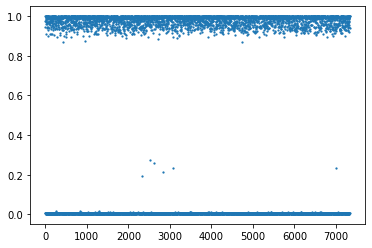

In [18]:
# plot the logistic output

plt.scatter(np.arange(0, first_model_training_predictions.shape[0]), 
            first_model_training_predictions['Logistic Output'], s = 1.5) # need to add actual values to this graph 


In [19]:
# obtain the predicted values on the TESTING data
logistic_output = pd.Series(model.predict(testing_data))

# write a threshold so to categorized each logistic output to a prediction 
first_model_testing_predictions = pd.DataFrame({'Logistic Output': logistic_output})
first_model_testing_predictions['Prediction'] = (first_model_testing_predictions['Logistic Output'].
                                        apply(lambda x: 1 if x >= 0.5 else 0))
first_model_testing_predictions['Actual Values'] = testing_data['y']

# display the training data
first_model_training_predictions.head()

,Logistic Output,Prediction,Actual Values
0,0.006099,0,0
1,0.945683,1,1
2,0.974047,1,1
3,0.999165,1,1
4,0.005114,0,0


In [20]:
# CALCULATING THE ERROR ON THE TESTING DATA
# the proportion of correctly classified winners

testing_error = (first_model_testing_predictions['Prediction'] == first_model_testing_predictions['Actual Values']).mean()
testing_error

0.9926821508113267

# MODEL 2: USES ONLY A SUBSET OF PREDICTORS

- use the training and testing data I made 
- iterate through each number of predictors (i.e, a model with 1 predictor, a model with 2 predictors, ... up to 20)
- do kfold cross validation on the training data with each model, and get the average cross validated training error
- choose the model with the smallest kfold error 
- using that chosen model, test it on the testing data

In [21]:
from sklearn.model_selection import KFold

In [22]:
equation_list = []

eq = 'y ~ 1' # baseline equation

for parameter in input_labels:
    eq = eq + ' + ' + parameter
    equation_list.append(eq)

In [23]:
fold_count = 5 # number of folds to split the data into
kf = KFold(n_splits = fold_count, random_state = 2, shuffle = True) # KFold transformer

training_error = {} # dictionary to store the avg training error of each model  
testing_error = {} # dictionary to store the avg testing error of each model 

parameter_counter = 1

for eq in equation_list[:16]:
    
    eq_testing_error = np.array([])
    eq_training_error = np.array([])
    
    # split the training data into 5 folds 
    for training, validation in kf.split(training_data):
    
        # get the folds for testing and validation
        train_data = training_data.loc[training]
        validation_data = training_data.loc[validation]
        
        # fit a logistic model on the training data
        model = logit(eq, data = train_data).fit()
        
        # make predictions using the model
        logistic_output_valid = pd.Series(model.predict(validation_data))
        predicted_values_valid = logistic_output_valid.apply(lambda x: 1 if x >= 0.5 else 0)
        
        logistic_output_train = pd.Series(model.predict(train_data))
        predicted_values_train = logistic_output_train.apply(lambda x: 1 if x >= 0.5 else 0)
        
        # calculate the error of the TRAINING data
        matches_training = (train_data.get('y') == predicted_values_train)
        error_train = matches_training.mean()
        
        # calculate the error of the VALIDATION data
        matches_validation = (validation_data.get('y') == predicted_values_valid)
        error_validation = matches_validation.mean()
        
        eq_training_error = np.append(eq_training_error, error_train)
        eq_testing_error = np.append(eq_testing_error, error_validation)
        
    training_error[parameter_counter] = eq_training_error.mean()
    testing_error[parameter_counter] = eq_testing_error.mean()
    
    parameter_counter += 1

Optimization terminated successfully.
         Current function value: 0.693132
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693076
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692916
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693029
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693104
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693131
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693072
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692893
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693021
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693101
  

c:\users\dylan\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.063053
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.049672
         Iterations 10


In [24]:
training_error

{1: 0.5066138126818531,
 2: 0.5065115690103232,
 3: 0.5136030050364627,
 4: 0.513841691766072,
 5: 0.8979953638765334,
 6: 0.9511453656402569,
 7: 0.9909995466619975,
 8: 0.9909995466619975,
 9: 0.9909995466619975,
 10: 0.9909995466619975,
 11: 0.9909995466619975,
 12: 0.9909995466619975,
 13: 0.9909995466619975,
 14: 0.9909995466619975,
 15: 0.9918177633531462,
 16: 0.9918177633531462}

In [25]:
model = logit(equation_list[16], data = training_data).fit()
training_predictions = pd.Series(model.predict(training_data)).apply(lambda x: 1 if x >= 0.5 else 0)
testing_predictions = pd.Series(model.predict(testing_data)).apply(lambda x: 1 if x >= 0.5 else 0)

matches_training = (training_predictions == training_data.get('y')).mean()
matches_testing = (testing_predictions == testing_data.get('y')).mean()

training_error[17] = matches_training
testing_error[17] = matches_testing

Optimization terminated successfully.
         Current function value: 0.061521
         Iterations 9


In [26]:
model = logit(equation_list[17], data = training_data).fit()
training_predictions = pd.Series(model.predict(training_data)).apply(lambda x: 1 if x >= 0.5 else 0)
testing_predictions = pd.Series(model.predict(testing_data)).apply(lambda x: 1 if x >= 0.5 else 0)

matches_training = (training_predictions == training_data.get('y')).mean()
matches_testing = (testing_predictions == testing_data.get('y')).mean()

training_error[18] = matches_training
testing_error[18] = matches_testing

Optimization terminated successfully.
         Current function value: 0.061385
         Iterations 10


In [27]:
model = logit(equation_list[18], data = training_data).fit()
training_predictions = pd.Series(model.predict(training_data)).apply(lambda x: 1 if x >= 0.5 else 0)
testing_predictions = pd.Series(model.predict(testing_data)).apply(lambda x: 1 if x >= 0.5 else 0)

matches_training = (training_predictions == training_data.get('y')).mean()
matches_testing = (testing_predictions == testing_data.get('y')).mean()

training_error[19] = matches_training
testing_error[19] = matches_testing

Optimization terminated successfully.
         Current function value: 0.061385
         Iterations 10


In [28]:
training_error

{1: 0.5066138126818531,
 2: 0.5065115690103232,
 3: 0.5136030050364627,
 4: 0.513841691766072,
 5: 0.8979953638765334,
 6: 0.9511453656402569,
 7: 0.9909995466619975,
 8: 0.9909995466619975,
 9: 0.9909995466619975,
 10: 0.9909995466619975,
 11: 0.9909995466619975,
 12: 0.9909995466619975,
 13: 0.9909995466619975,
 14: 0.9909995466619975,
 15: 0.9918177633531462,
 16: 0.9918177633531462,
 17: 0.99181780990045,
 18: 0.99181780990045,
 19: 0.99181780990045}

In [29]:
testing_error

{1: 0.48916136819952555,
 2: 0.4845255000646326,
 3: 0.5059339112126631,
 4: 0.5051153573245322,
 5: 0.8979953706416097,
 6: 0.9511775663040739,
 7: 0.9909988831138155,
 8: 0.9909988831138155,
 9: 0.9909988831138155,
 10: 0.9909988831138155,
 11: 0.9909988831138155,
 12: 0.9909988831138155,
 13: 0.9909988831138155,
 14: 0.9909988831138155,
 15: 0.9918170650165393,
 16: 0.9918170650165393,
 17: 0.9926821508113267,
 18: 0.9926821508113267,
 19: 0.9926821508113267}

Text(0.5, 1.0, 'Accuracy of Logistic Models with Varying Number of Parameters on Training Data')

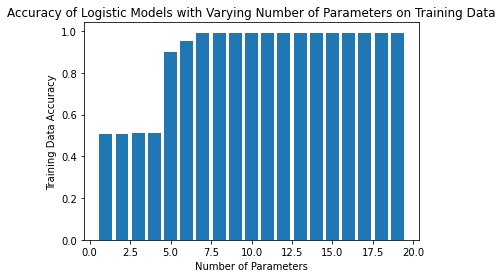

In [30]:
plt.bar(list(training_error.keys()), list(training_error.values()))
plt.xlabel('Number of Parameters')
plt.ylabel('Training Data Accuracy')
plt.title('Accuracy of Logistic Models with Varying Number of Parameters on Training Data')

Text(0.5, 1.0, 'Accuracy of Logistic Models with Varying Number of Parameters on Testing Data')

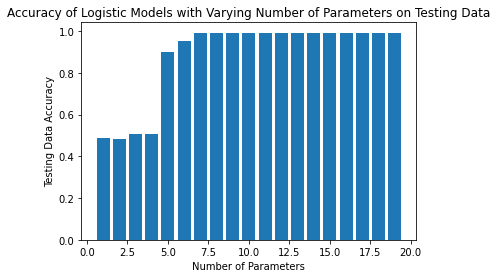

In [31]:
plt.bar(list(testing_error.keys()), list(testing_error.values()))
plt.xlabel('Number of Parameters')
plt.ylabel('Testing Data Accuracy')
plt.title('Accuracy of Logistic Models with Varying Number of Parameters on Testing Data')

In [32]:
# based off a high accuracy yet small number of parameters, we choose the 7th model
chosen_model = equation_list[6] # 7th model is the best
chosen_model

'y ~ 1 + ct_alive + t_alive + is_bomb_planted + is_ct + Ct_Eq_Val + T_Eq_Val + Is_Overpass'

We expect that a majority of the time, both teams (Terrorist and Counter Terrorists) will have the same strenght of weapons with little rounds of mismatch (i.e., pistols vs full econ) so the weapons are negligible given that they are usually the same across both teams

In [33]:
final_model = logit(chosen_model, data = shuffled_data).fit()
final_model.summary()

Optimization terminated successfully.
         Current function value: 0.091738
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                10476
Model:                          Logit   Df Residuals:                    10468
Method:                           MLE   Df Model:                            7
Date:                Thu, 03 Jun 2021   Pseudo R-squ.:                  0.8677
Time:                        23:54:55   Log-Likelihood:                -961.05
converged:                       True   LL-Null:                       -7261.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.2494      0.318     -0.785      0.433      -0.872       0.373
ct_alive            0.0818      0.061      1.339      0.181      -0.038       0.202
t_alive            -0.0091      0.053     -0.172      0.864      -0.113       0.095
is_bomb_planted     0.0279      0.202      0.138      0.890      -0.367       0.423
is_ct              -0.1845      0.163     -1.130      0.258      -0.505       0.136
Ct_Eq_Val           0.0004   1.04e-05     37.814      0.000       0.000       0.000
T_Eq_Val            0.0003   8.71e-06     34.042      0.000       0.000       0.000
Is_Overpass        -6.9031      0.237    -29.113      0.000      -7.368      -6.438
===================================================================================

Possibly complete quasi-separation: A fraction 0.19 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [34]:
logistic_output = final_model.predict()
predictions = pd.Series(logistic_output).apply(lambda x: 1 if x >= 0.5 else 0)

In [35]:
final_error = (predictions == shuffled_data.get('y')).mean()
final_error

0.9914089347079038

Text(0.5, 1.0, 'Logistic Outputs of Dataset Observations')

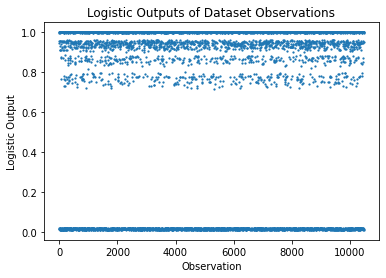

In [36]:
#plt.scatter(shuffled_data.index, shuffled_data.get('y'))
plt.scatter(predictions.index, logistic_output, s = 1.5)
plt.ylabel('Logistic Output')
plt.xlabel('Observation')
plt.title('Logistic Outputs of Dataset Observations')